In [1]:
import itertools
import random
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Adam
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
class SequentialMNISTDataset(Dataset):
    """
    A custom dataset for sequential MNIST, where each 28×28 image is treated
    as a sequence of length 28, with each time step receiving 28 input features.
    """

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        seq = img.squeeze(0)
        return seq, label

In [3]:
class Net(nn.Module):
    def __init__(self, input_dim=28, hidden_dim=128, output_dim=10, num_layers=1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Zero initialization
        nn.init.zeros_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # RNN layer
        #out, h = self.rnn(x)
        # LSTM layer
        out, (h, c) = self.lstm(x)

        # Use the final time step's output for classification
        out = out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)

        return F.softmax(out, dim=1)

In [4]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

        self.loss_log, self.acc_log = [], []

    def train(self, dataloader):
        self.model.train()
        running_loss = 0
        running_correct = 0
        total_samples = 0

        for batch_idx, (data, targets) in enumerate(dataloader):
            data, targets = data.to(self.device), targets.to(self.device)

            # Forward pass
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)

            # Backprop
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == targets).sum().item()
            running_correct += correct
            running_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

            self.loss_log.append(loss.item())
            self.acc_log.append(correct/len(targets))

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        return epoch_loss, epoch_acc

    def evaluate(self, dataloader):
        self.model.eval()
        running_loss = 0
        running_correct = 0
        total_samples = 0

        with torch.no_grad():
            for data, targets in dataloader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)

                loss = self.criterion(outputs, targets)
                _, predicted = torch.max(outputs.data, 1)

                running_correct += (predicted == targets).sum().item()
                running_loss += loss.item() * data.size(0)
                total_samples += data.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        return epoch_loss, epoch_acc


def plot_curves(loss_log, val_loss_log, acc_log, val_acc_log, train_dataset_size, batch_size):
    fig, ax1 = plt.subplots(figsize=(16, 9))

    color = 'tab:red'
    # Plot train & val loss
    ax1.plot(range(len(loss_log)), loss_log, c=color, alpha=0.25, label="Train Loss")
    ax1.plot(
        [np.ceil((i + 1) * train_dataset_size / batch_size) for i in range(len(val_loss_log))],
        val_loss_log,
        c="red",
        label="Val. Loss"
    )
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Avg. Cross-Entropy Loss", c=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(-0.01, 3)

    ax2 = ax1.twinx()
    color = 'tab:blue'

    # Plot train & val accuracy
    ax2.plot(range(len(acc_log)), acc_log, c=color, label="Train Acc.", alpha=0.25)
    ax2.plot(
        [np.ceil((i + 1) * train_dataset_size / batch_size) for i in range(len(val_acc_log))],
        val_acc_log,
        c="blue",
        label="Val. Acc."
    )
    ax2.set_ylabel("Accuracy", c=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.01, 1.01)

    fig.tight_layout()
    ax1.legend(loc="center")
    ax2.legend(loc="center right")
    plt.show()

[Epoch 1]   Loss:  2.093795916557312     Train Acc:  36.085%      Val Acc:  62.160000000000004%
[Epoch 2]   Loss:  1.7506844630559286     Train Acc:  72.24166666666667%      Val Acc:  87.64%
[Epoch 3]   Loss:  1.5687367775599161     Train Acc:  90.09833333333333%      Val Acc:  92.52%
[Epoch 4]   Loss:  1.541982460975647     Train Acc:  92.59666666666668%      Val Acc:  94.71000000000001%
[Epoch 5]   Loss:  1.532404712231954     Train Acc:  93.55666666666667%      Val Acc:  94.1%
[Epoch 6]   Loss:  1.5198702217102051     Train Acc:  94.71000000000001%      Val Acc:  96.03%
[Epoch 7]   Loss:  1.5182585594177247     Train Acc:  94.90666666666667%      Val Acc:  95.23%
[Epoch 8]   Loss:  1.514510994466146     Train Acc:  95.21833333333333%      Val Acc:  95.30999999999999%
[Epoch 9]   Loss:  1.5101469170252482     Train Acc:  95.66166666666666%      Val Acc:  96.5%
[Epoch 10]   Loss:  1.5116826563517252     Train Acc:  95.47666666666666%      Val Acc:  95.96000000000001%
[Epoch 11]   Loss

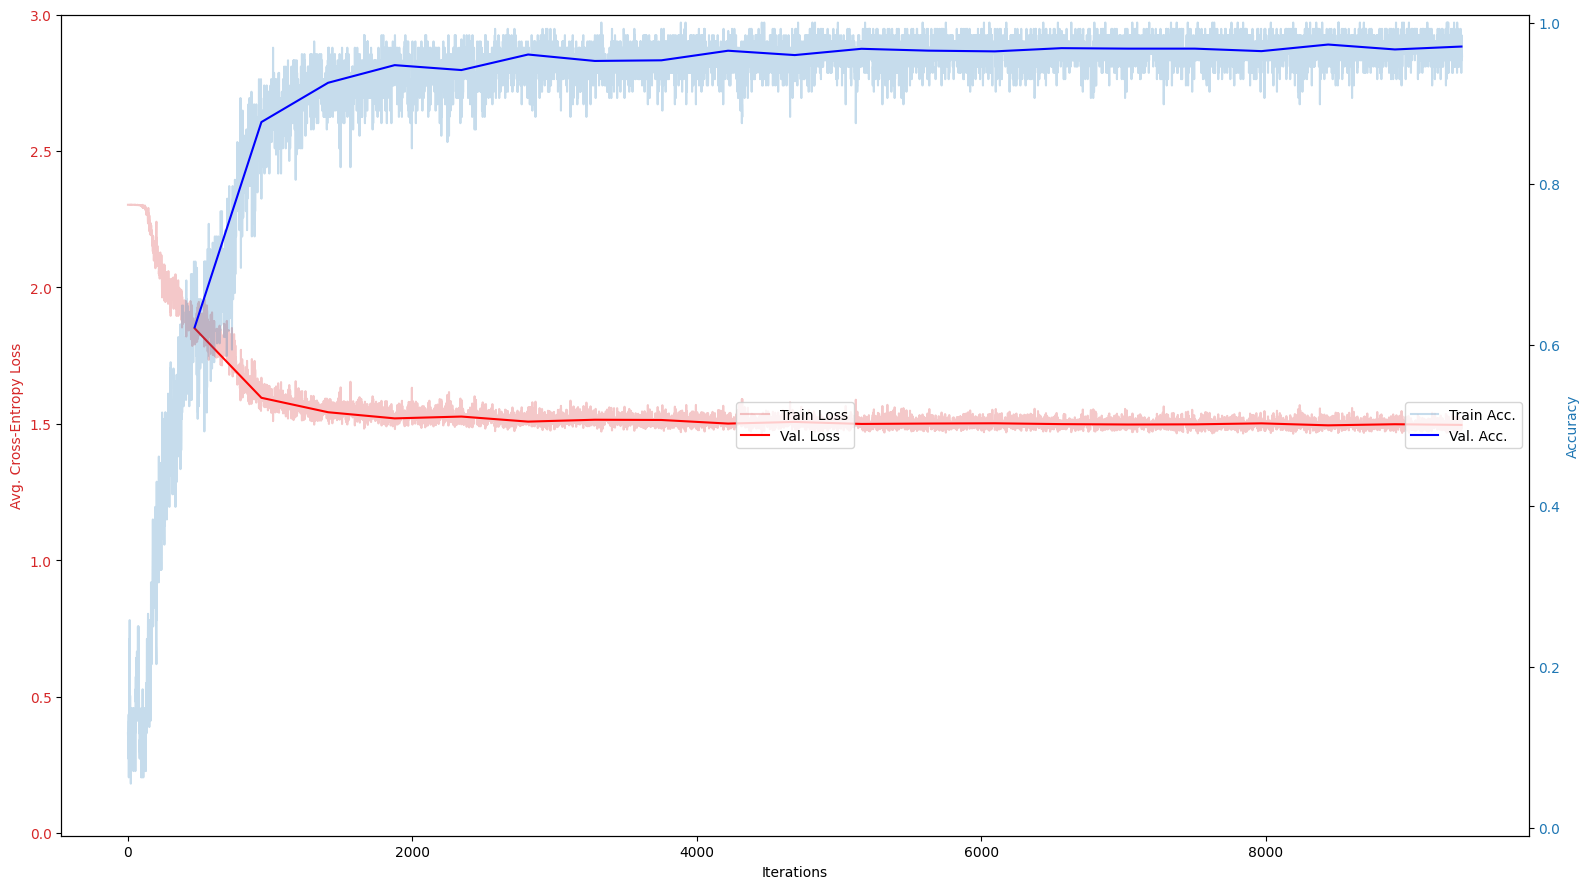

In [5]:
def main():
    # Hyperparameters
    max_epochs = 20
    batch_size = 128
    lr = 1e-3
    weight_decay = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the MNIST dataset
    train_data = datasets.MNIST(
        root='./mnist_data/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )
    val_data = datasets.MNIST(
        root='./mnist_data/',
        train=False,
        transform=transforms.ToTensor()
    )

    # Organize the MNIST dataset into SequentialMNISTDataset
    train_seq_data = SequentialMNISTDataset(train_data)
    val_seq_data = SequentialMNISTDataset(val_data)

    # Data loaders
    train_loader = DataLoader(train_seq_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_seq_data, batch_size=batch_size, shuffle=False, num_workers=2)

    # Example of fetching a batch
    example_data, example_targets = next(iter(train_loader))

    # Initialize model, optimizer, and loss function
    model = Net().to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    loss_log, val_loss_log = [], []
    acc_log, val_acc_log = [], []
    # Training loop
    trainer = Trainer(model, criterion, optimizer, device)
    for epoch in range(max_epochs):
        train_loss, train_acc = trainer.train(train_loader)
        val_loss, val_acc = trainer.evaluate(val_loader)

        # Log per epoch results
        print(f"[Epoch {epoch + 1}]   Loss:  {train_loss}     Train Acc:  {train_acc * 100}%      Val Acc:  {val_acc * 100}%")

        #if len(val_loss_log) != 0 and val_loss_log[-1] > val_loss:
        #    torch.save(model.state_dict(), './model.pt')

        # Save epoch-level logs
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        # For iteration-level logs
        #loss_log.append(train_loss)
        #acc_log.append(train_acc)

    # Plot training curves
    plot_curves(trainer.loss_log, val_loss_log, trainer.acc_log, val_acc_log, len(train_data), batch_size)


if __name__ == "__main__":
    main()